# CO Freezeout 
Script to calculate the freeze-out from C18O 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

import math
from astropy.constants import h, k_B, c

In [ ]:
hdu_c180 = fits.open('./data/c18o_mom0_reprojected.fits')[0]

hdu_N_H2 = fits.open('./data/coldense_H2.fits')[0]

In [ ]:
def compute_g_j(j):
    """g-factors from quantum numbers"""
    return (2 * j) + 1

def compute_wavelength(freq):
    """Wavelength (m) from the frequency (Hz)"""
    return (c / freq).to(u.cm)

def compute_E_j(j, B):
    """Energy of the energy of level (J)"""
    return j * (j + 1) * h * B

def _compute_Q_rot(j, E_j, T_ex):
    """Compute the partition function for a molecule given the excitation temperature and rotational constant."""
    return (2 * j + 1) * np.exp((-E_j / (k_B * T_ex)).decompose().value)

def compute_partition_function(T_ex, B, maxJ=10):
    """
    Compute the partition function for a molecule given the excitation
    temperature and rotational constant.
    """
    Q_rot = 0.0
    for j in range(maxJ):
        E_j = compute_E_j(j, B)
        Q_rot += _compute_Q_rot(j, E_j, T_ex)
    return Q_rot

def compute_J_T(T, freq):
    """equivalent Rayleigh-Jeans temperatures"""
    return (h * freq / k_B) / (np.exp((h * freq / (k_B * T)).decompose().value) - 1.0)

def compute_column_density(I, eI, T_ex, T_bg,
                           freq, A, B, q_l, q_u, maxJ=10):
    """
    Compute the column density and its error for a molecular transition,
    given its integrated intensity (in K km/s) and associated error.

    Parameters
    ----------
    I : astropy.units.Quantity
        Integrated intensity in K km/s.
    eI : astropy.units.Quantity
        Uncertainty in the integrated intensity (same units as I).
    T_ex : float
        Excitation temperature in K.
    T_bg : float
        Background temperature in K.
    freq : astropy.units.Quantity
        Transition frequency (e.g., in Hz).
    A : float
        Einstein A coefficient (s^-1).
    B : astropy.units.Quantity
        Rotational constant (in Hz).
    l : float
        Lower rotational quantum number.
    u : float
        Upper rotational quantum number.
    maxJ : int, optional
        Maximum quantum number used in the partition function sum (default=10).
        
    Returns
    -------
    N : astropy.units.Quantity
        Column density in cm^-2.
    eN : astropy.units.Quantity
        Uncertainty in the column density in cm^-2.
    """
    # -----------------------------
    # Fundamental constants and derived quantities
    # -----------------------------
    # g-factors from quantum numbers
    g_l = compute_g_j(q_l)
    g_u = compute_g_j(q_u)

    # Wavelength (m) from the frequency (Hz)
    wavelength = compute_wavelength(freq) # c in m/s, freq in Hz → wavelength in m
    print('Wavelength', wavelength)
    print('hv/k', (h * freq / k_B).to('K'))

    # Energy of the lower level (J)
    E_l = compute_E_j(q_l, B)
    print('E_l', E_l)

    # -----------------------------
    # Partition function: Q_rot = sum_{j=0}^{maxJ-1} (2j+1) exp[-E_j/(k_B T_ex)]
    # where E_j = j(j+1) h B.
    # -----------------------------
    Q_rot = compute_partition_function(T_ex, B, maxJ=maxJ)
    print('Q_rot', Q_rot)
    
    # -----------------------------
    # Brightness temperature correction:
    # J(T) = (h*nu/k_B) / (exp(h*nu/(k_B*T)) - 1)
    # -----------------------------
    # Note: we use .decompose().value to work with dimensionless arguments inside np.exp.
    J_ex = compute_J_T(T_ex, freq)
    J_bg = compute_J_T(T_bg, freq)
    print('J_ex', J_ex)
    print('J_bg', J_bg)
    
    # -----------------------------
    # Compute the prefactor (fcol) in the column density equation:
    #
    # N = fcol * (integrated intensity)    where:
    #
    #   fcol = (8π/(λ^3 A)) * (g_l/g_u) * 1/(J_ex - J_bg) *
    #          1/(1 - exp(-h*freq/(k_B*T_ex))) * Q_rot *
    #          1/(g_l * exp(-E_l/(k_B*T_ex)))
    # -----------------------------
    top_factor      = (8 * np.pi) / (wavelength**3 * A)
    factor_degen    = g_l / g_u
    factor_J        = 1.0 / (J_ex - J_bg)
    factor_exp_term = 1.0 / (1.0 - np.exp((-h * freq / (k_B * T_ex)).decompose().value))
    factor_level    = Q_rot / (g_l * np.exp((-E_l / (k_B * T_ex)).decompose().value))
    
    fcol = top_factor * factor_degen * factor_J * factor_exp_term * factor_level
    
    # -----------------------------
    # Compute the column density (N) in cm^-2.
    # (I is in K km/s; 'conv' converts to appropriate base units.)
    # -----------------------------
    N_val = I *  fcol
    N_err = eI * fcol

    # Likely the units come out as m^-2; convert to cm^-2.
    N = N_val.to(u.cm**-2)
    N_err = N_err.to(u.cm**-2)
    
    return N, N_err

3.1971731898702926
C18O Column Density (cm^-2) at 1 K/kms: 5.12e+19


In [ ]:
# ------------------------------------------------------------------------------
# Example usage for C18O (1–0)
# ------------------------------------------------------------------------------

I_c18o  = 1.0 * u.K * u.km / u.s   # example integrated intensity
eI_c18o = 0.1 * u.K * u.km / u.s   # example uncertainty
T_ex    = 7.5                  # excitation temperature in K (typical for CO)
T_bg    = 2.72548                # background (CMB) temperature in K

# Constants for C18O (1–0)
freq_c18o = 109.7821734e9 * u.Hz   # frequency in Hz 
A_c18o    = 6.266e-8 / u.s         # Einstein A coefficient in s^-1 
B_c18o    = 54.89142e9 * u.Hz      # Rotational constant in Hz
l_c18o    = 0.0                  # lower level quantum number (J = 0)
u_c18o    = 1.0                  # upper level quantum number (J = 1)

N_c18o, eN_c18o = compute_column_density(I_c18o, eI_c18o,
                                         T_ex, T_bg,
                                         freq_c18o, A_c18o, B_c18o,
                                         l_c18o, u_c18o, maxJ=10)
print("\nC18O (1–0):")
print("  Column density =", N_c18o.to(u.cm**-2)/1e14)
print("  Error           =", eN_c18o.to(u.dex(u.cm**-2)))

In [24]:
hdu_f_D = fits.PrimaryHDU(f_D.value, header=header_c180)
hdu_f_D.writeto('./data/f_D.fits', overwrite=True)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_17465/1945690250.py:4: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(N_H2_ext.value.flatten()), bins=100, histtype='step', label='N_H2_ext')


Text(0, 0.5, 'N')

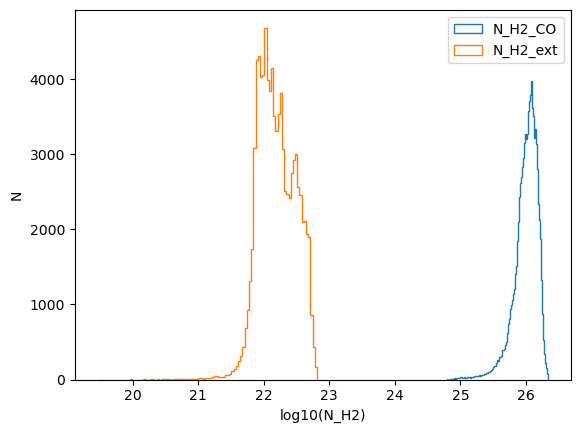

In [25]:
# plot hist of N_H2
plt.figure()
plt.hist(np.log10(N_H2_CO.value.flatten()), bins=100, histtype='step', label='N_H2_CO')
plt.hist(np.log10(N_H2_ext.value.flatten()), bins=100, histtype='step', label='N_H2_ext')
plt.legend()
plt.xlabel('log10(N_H2)')
plt.ylabel('N')

Text(0, 0.5, 'N')

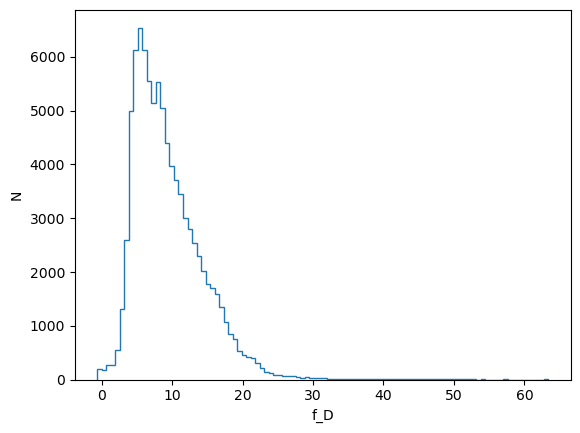

In [6]:
# plot hist of f_D
plt.figure()
plt.hist(f_D.value.flatten(), bins=100, histtype='step')
plt.xlabel('f_D')
plt.ylabel('N')